In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import t
import time

In [17]:
alpha = 0.1
eps = 0.001
steps = 1000

In [10]:
def var(y_orig, y_pred):
    cost = 0
    cost += ((y_orig - y_pred) ** 2)
    cost = cost.sum()
    return cost

In [11]:
def mse(y_orig, y_pred):
    return var(y_orig, y_pred) / y_orig.shape[0]

In [12]:
def R_sq(y_orig, y_pred):
    n = len(y_orig)
    return (y_orig.var()*(n-1) - var(y_orig, y_pred)) / (y_orig.var()*(n-1))

In [74]:
def RSE(y, y_pred, df):
    n = len(y)
    return math.sqrt(var(y, y_pred)/(n - df))

In [64]:
def gradient_descent(X, y, w, b, alpha):
    n = len(X)
    y_pred = w * X + b
    error = y_pred - y

    dw = 2 * np.dot(X, error) / (n - 1)
    db = 2 * np.sum(error) / (n - 1)

    w_new = w - alpha * dw
    b_new = b - alpha * db

    return (w_new, b_new)

In [39]:
def my_fit(X, y):
    w, b = (0, 0)
    std = X.std()
    mean = X.mean()
    X_scaled = (X - mean)/std

    w_history = []
    b_history = []
    
    for step in range(steps):
        w_new, b_new = gradient_descent(X_scaled, y, w, b, alpha)
        w_history.append(w_new)
        b_history.append(b_new)
        if abs(w_new - w) < eps and abs(b_new - b) < eps:
            break
        w, b = (w_new, b_new)

    w_orig = w/std
    b_orig = b - (w * mean)/std
    
    return (w_orig, b_orig, w_history, b_history)

In [81]:
def SE_b(X, y, y_pred, df):
    n = len(X)
    res_var = var(y, y_pred) / (n - df)
    squared_error = X.var() * (n-1)
    mean = X.mean()
    
    
    return math.sqrt(res_var * (1/n + (mean**2)/squared_error))

def SE_w(X, y, y_pred, df):
    n = len(X)
    res_var = var(y, y_pred) / (n - df)
    squared_error = X.var() * (n-1)

    return math.sqrt(res_var / squared_error)

In [82]:
def t_stat_b(X, y, y_pred, b, df):
    stan_err = SE_b(X, y, y_pred, df)
    t = b / stan_err
    return t

def t_stat_w(X, y, y_pred, w, df):
    stan_err = SE_w(X, y, y_pred, df)
    t = w / stan_err
    return t

In [93]:
def p_value_b(X, y, y_pred, b, df):
    n = len(X)
    tb = t_stat_b(X, y, y_pred, b, df)
    return 2 * t.sf(np.abs(tb), n - 2)

def p_value_w(X, y, y_pred, w, df):
    n = len(X)
    tw = t_stat_w(X, y, y_pred, w, df)
    return 2 * t.sf(np.abs(tw), n - 2)

In [187]:
df = pd.read_csv('../student_habits_performance_changed.csv')

# Exam Score by Study Hours per day

## My Implmentation

In [65]:
X = df['study_hours_per_day']
y = df['exam_score']

In [179]:
start_time = time.perf_counter()
w, b, w_history, b_history = my_fit(X, y)
stop_time = time.perf_counter()
y_pred = w * X + b

duration_implementation = stop_time - start_time
print(w, b)
print('duration(s): ', duration_implementation)

9.489604532922673 35.90776882000508
duration(s):  0.012434851000762137


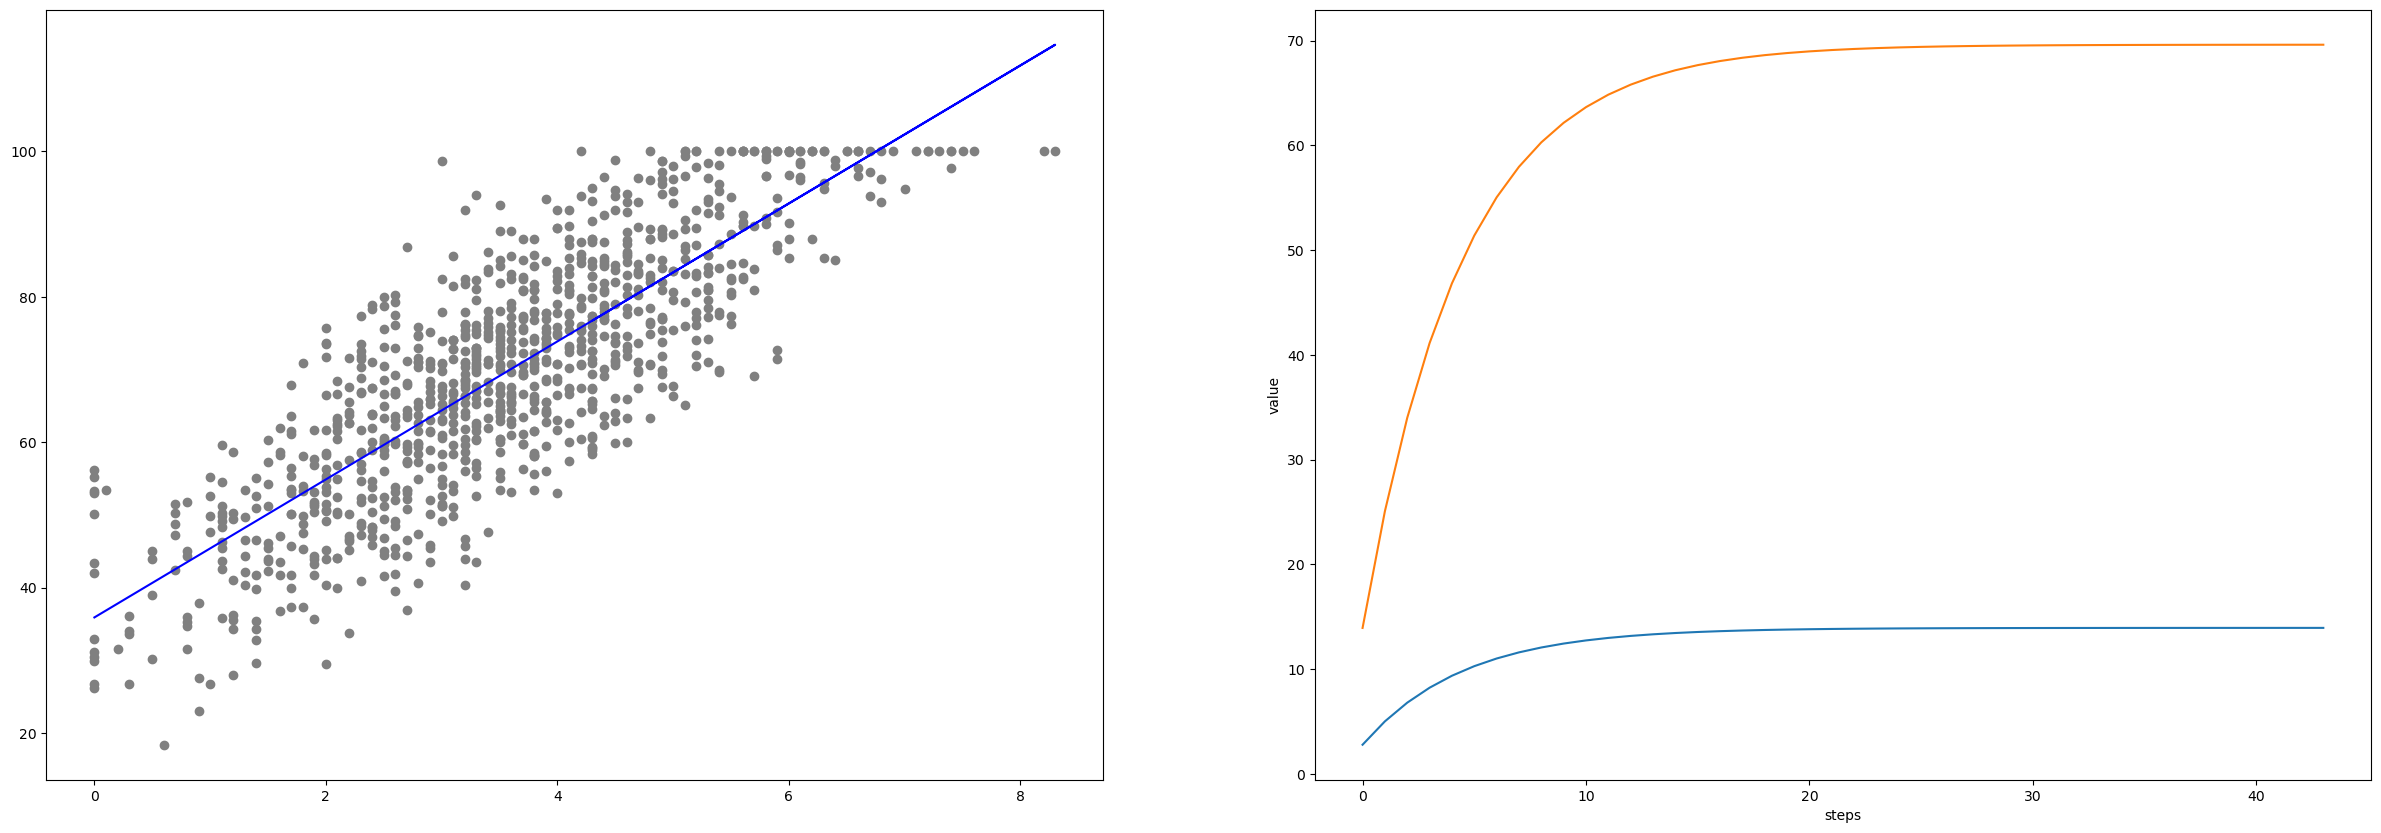

In [138]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))

axs[0].scatter(x=df['study_hours_per_day'], y=df['exam_score'], color='gray')
axs[0].plot(X, y_pred, color='blue')

axs[1].set(xlabel='steps')
axs[1].set(ylabel='value')
axs[1].plot(w_history)
axs[1].plot(b_history)

In [100]:
tb = t_stat_b(X, y, y_pred, b, 2)
tw = t_stat_w(X, y, y_pred, w, 2)
pb = p_value_b(X, y, y_pred, b, 2)
pw = p_value_w(X, y, y_pred, b, 2)
r_sq = R_sq(y, y_pred)
rse = RSE(y, y_pred, 2)

45.49314269774506 46.18804053060686
1.377993915942882e-245 0.0
0.6813156354293787
9.538730388424073


In [117]:
df_values = pd.DataFrame(columns=['Quantity', 'Value'])
df_values['Quantity'] = ['b t-statistic', 'b p-value', 'w t-statistic', 'w p-value', "R^2", 'RSE']
df_values = df_values.set_index('Quantity')
df_values.loc['b t-statistic', 'Value'] = tb
df_values.loc['b p-value', 'Value'] = pb
df_values.loc['w t-statistic', 'Value'] = tw
df_values.loc['w p-value', 'Value'] = pw
df_values.loc['R^2', 'Value'] = r_sq
df_values.loc['RSE', 'Value'] = rse
df_values

,Value
Quantity,
b t-statistic,45.493143
b p-value,0.0
w t-statistic,46.188041
w p-value,0.0
R^2,0.681316
RSE,9.53873


## Sklearn Implementation

In [182]:
X_fit = df[['study_hours_per_day']]

start_time = time.perf_counter()
reg = LinearRegression().fit(X_fit, y)
stop_time = time.perf_counter()

duration_sklearn = stop_time - start_time
print('duration(s): ', duration)

duration(s):  0.0015617929993823054


In [183]:
w = reg.coef_
b = reg.intercept_
y_pred = w * X + b
print(reg.coef_, reg.intercept_)

[9.49025041] 35.91016203402567


[Text(0, 0.5, 'value')]

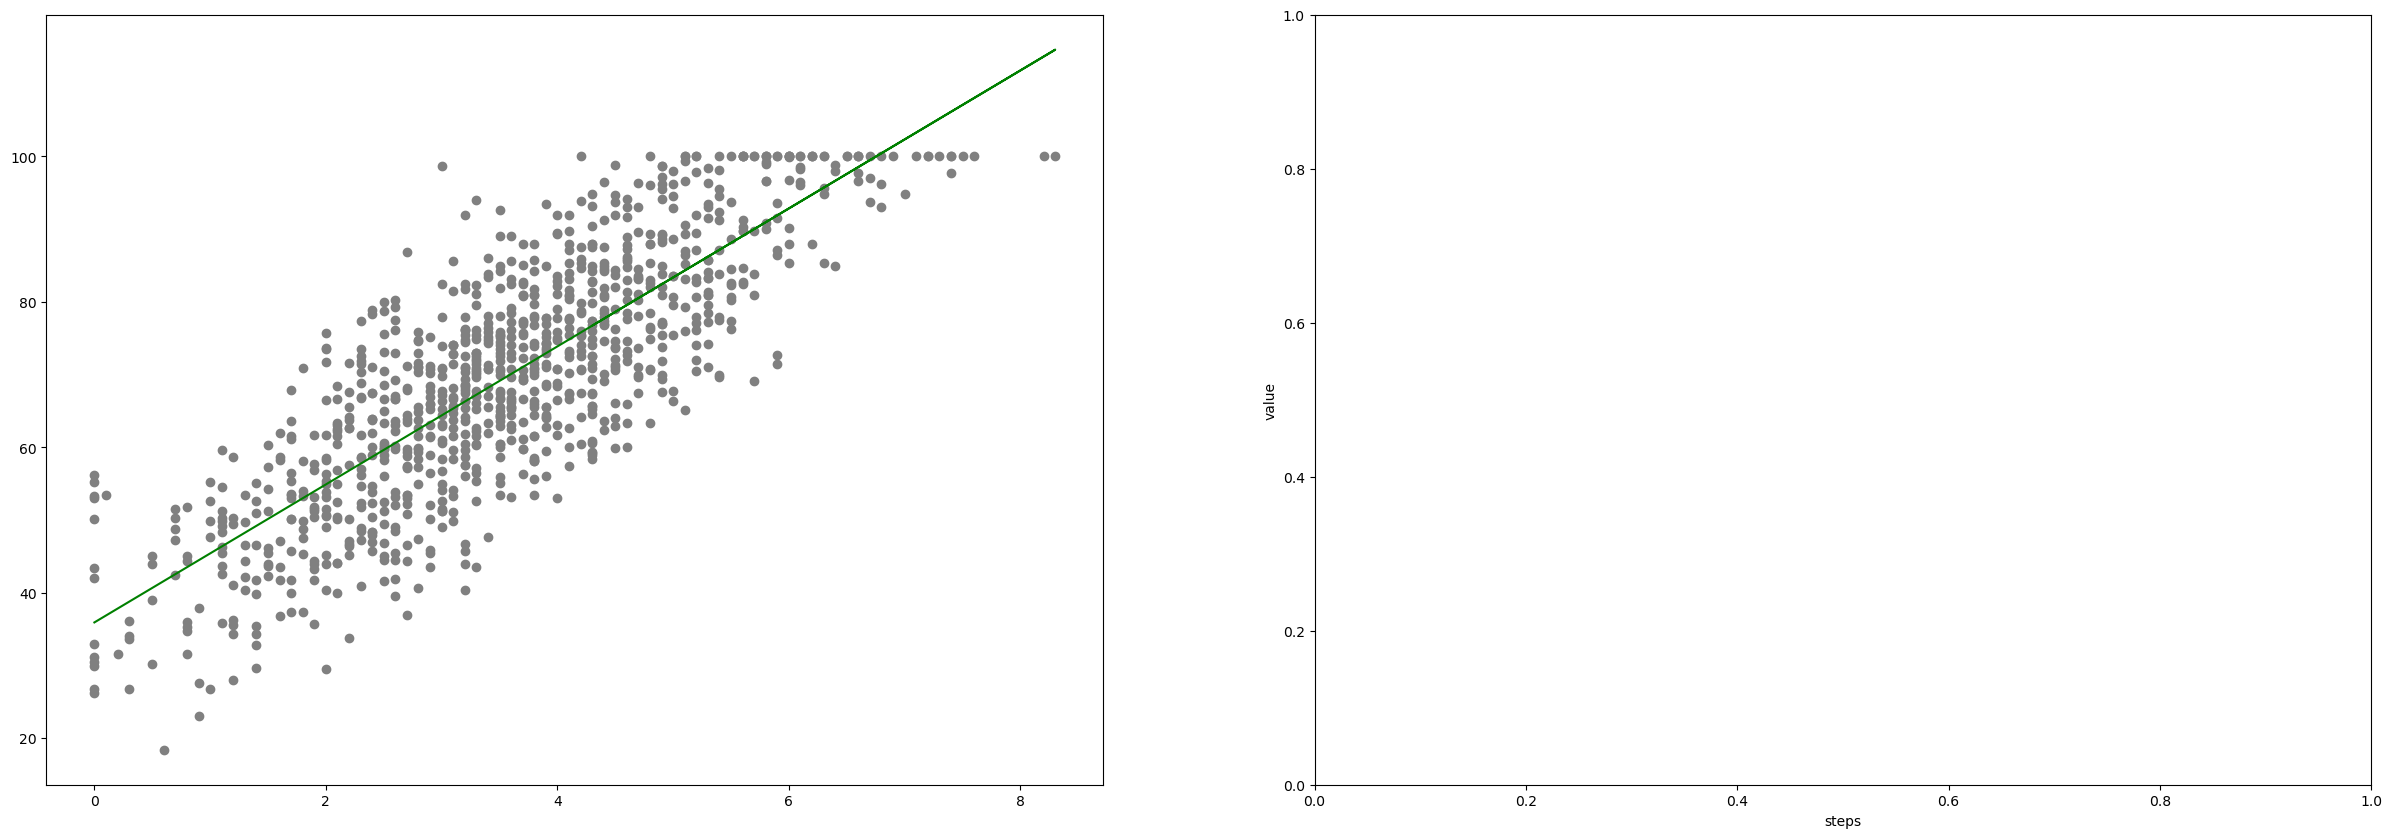

In [184]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))

axs[0].scatter(x=df['study_hours_per_day'], y=df['exam_score'], color='gray')
axs[0].plot(X, y_pred, color='green')

axs[1].set(xlabel='steps')
axs[1].set(ylabel='value')

In [185]:
tb = t_stat_b(X, y, y_pred, b, 2)
tw = t_stat_w(X, y, y_pred, w, 2)
pb = p_value_b(X, y, y_pred, b, 2)
pw = p_value_w(X, y, y_pred, b, 2)
r_sq = R_sq(y, y_pred)
rse = RSE(y, y_pred, 2)
df_values = pd.DataFrame(columns=['Quantity', 'Value'])
df_values['Quantity'] = ['b t-statistic', 'b p-value', 'w t-statistic', 'w p-value', "R^2", 'RSE']
df_values = df_values.set_index('Quantity')
df_values.loc['b t-statistic', 'Value'] = tb
df_values.loc['b p-value', 'Value'] = pb
df_values.loc['w t-statistic', 'Value'] = tw
df_values.loc['w p-value', 'Value'] = pw
df_values.loc['R^2', 'Value'] = r_sq
df_values.loc['RSE', 'Value'] = rse
df_values

,Value
Quantity,
b t-statistic,45.49618
b p-value,0.0
w t-statistic,46.1911899536853
w p-value,0.0
R^2,0.681316
RSE,9.538729


# Exam Score By Mental Health Status

## Own Implementation

In [188]:
df.columns

Index(['student_id', 'age', 'gender', 'study_hours_per_day',
       'social_media_hours', 'netflix_hours', 'part_time_job',
       'attendance_percentage', 'sleep_hours', 'diet_quality',
       'exercise_frequency', 'parental_education_level', 'internet_quality',
       'mental_health_rating', 'extracurricular_participation', 'exam_score'],
      dtype='str')

In [233]:
X = df['mental_health_rating']
y = df['exam_score']

w, b, w_hist, b_hist = my_fit(X, y)
y_pred = w * X + b
print(f"w: {w}\nb: {b}")

w: 1.9068264556820627
b: 59.227491606334794


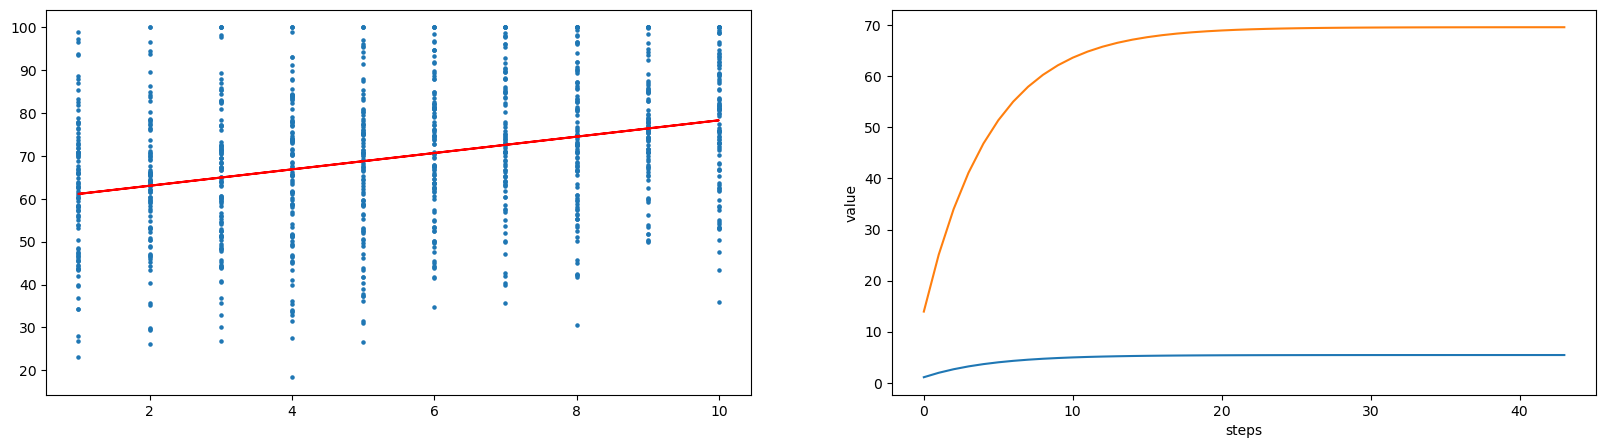

In [234]:
fig, ax = plt.subplots(figsize=(20,5), nrows=1, ncols=2)
s = 5
ax[0].scatter(x=X, y=y, s=s)
ax[0].plot(X, y_pred, color='red')

ax[1].set(xlabel='steps', ylabel='value')
ax[1].plot(w_hist)
ax[1].plot(b_hist)

In [235]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             exam_score   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     115.1
Date:                Mon, 16 Feb 2026   Prob (F-statistic):           1.75e-25
Time:                        17:15:30   Log-Likelihood:                -4190.5
No. Observations:                1000   AIC:                             8385.
Df Residuals:                     998   BIC:                             8395.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   59.2315 

In [217]:
tb = t_stat_b(X, y, y_pred, b, 2)
tw = t_stat_w(X, y, y_pred, w, 2)
pb = p_value_b(X, y, y_pred, b, 2)
pw = p_value_w(X, y, y_pred, b, 2)
r_sq = R_sq(y, y_pred)
rse = RSE(y, y_pred, 2)
df_values = pd.DataFrame(columns=['Quantity', 'Value'])
df_values['Quantity'] = ['b t-statistic', 'b p-value', 'w t-statistic', 'w p-value', "R^2", 'RSE']
df_values = df_values.set_index('Quantity')
df_values.loc['b t-statistic', 'Value'] = tb
df_values.loc['b p-value', 'Value'] = pb
df_values.loc['w t-statistic', 'Value'] = tw
df_values.loc['w p-value', 'Value'] = pw
df_values.loc['R^2', 'Value'] = r_sq
df_values.loc['RSE', 'Value'] = rse
df_values

,Value
Quantity,
b t-statistic,54.280712
b p-value,0.0
w t-statistic,10.726121
w p-value,0.0
R^2,0.103377
RSE,15.999822


# Exam Score By Social Media Hours

## Sklearn Implemenation

In [8]:
df = pd.read_csv('../student_habits_performance_changed.csv')

In [9]:
X = df[['social_media_hours']]
y = df['exam_score']

In [10]:
reg = LinearRegression().fit(X, y)

In [11]:
w = reg.coef_
b = reg.intercept_
y_pred = w * X + b

In [12]:
print(w, b)

[-2.40176147] 75.61911336278644


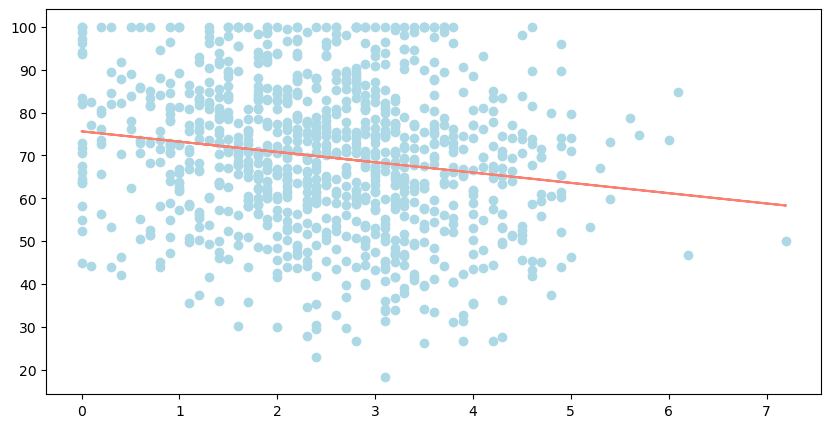

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(X, y, color='lightblue')
ax.plot(X, y_pred, color='salmon')

In [14]:
from sklearn import datasets, linear_model
import statsmodels.api as sm
from scipy import stats

In [23]:
X2 = sm.add_constant(X)
print(X.shape, X2)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

(1000, 1)      const  social_media_hours
0      1.0                 1.2
1      1.0                 2.8
2      1.0                 3.1
3      1.0                 3.9
4      1.0                 4.4
..     ...                 ...
995    1.0                 0.5
996    1.0                 1.0
997    1.0                 2.6
998    1.0                 4.1
999    1.0                 2.9

[1000 rows x 2 columns]
                                 OLS Regression Results                                
Dep. Variable:             exam_score   R-squared (uncentered):                   0.746
Model:                            OLS   Adj. R-squared (uncentered):              0.746
Method:                 Least Squares   F-statistic:                              2933.
Date:                Tue, 17 Feb 2026   Prob (F-statistic):                   1.85e-299
Time:                        17:46:56   Log-Likelihood:                         -5005.3
No. Observations:                1000   AIC:                     